In [11]:
import pandas as pd
import numpy as np

def generate_data() -> pd.DataFrame:
    """
    Generates a simple DataFrame with 1000 samples where 'Price'
    is in a noisy linear relationship with 'Surface'.
    """
    # Generate 1000 random surface values (input attribute)
    surface = np.random.rand(1000) * 250 + 50  # Surfaces between 50 and 300

    # Calculate price with a linear formula + random noise
    price = 5000 * surface + 100000 + np.random.randn(1000) * 5000

    # Create and return the DataFrame
    df = pd.DataFrame({
        'Surface': surface.round(1),
        'Price': price.round(0)
    })
    return df

# --- Example Usage ---

# Generate the data
my_data = generate_data()

# Print the first 5 rows
print(my_data.head())

   Surface      Price
0     84.4   514101.0
1    217.1  1189904.0
2    263.4  1413004.0
3    246.0  1332992.0
4     76.6   483546.0


In [12]:
from sklearn.model_selection import train_test_split


# features and target
X = my_data[['Surface']]
y = my_data['Price']

# split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (800, 1), X_test: (200, 1)
y_train: (800,), y_test: (200,)


Training complete.
Learned Slope (Weight): 0.9999
Learned Intercept (Bias): 0.0000
------------------------------
Method 1 test RMSE: 4,758.54
Method 1 test MAE: 3,729.12
Method 1 test R2: 0.9998
Prediction results on the test set (first 5 rows):
     Surface  Actual Price  Predicted Price
521    224.7     1226311.0        1223531.0
737    146.6      824324.0         832753.0
740    119.3      695643.0         696156.0
660    279.0     1495765.0        1495224.0
411    228.6     1243648.0        1243045.0


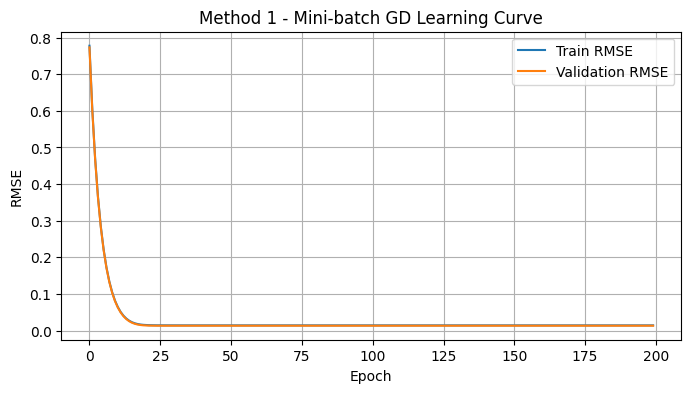

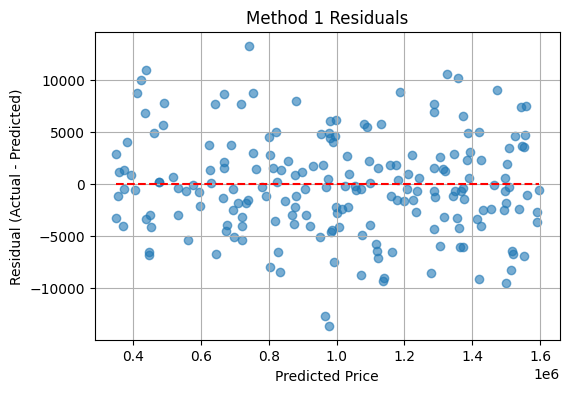

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

def minibatch_gradient_descent(X, y, X_val=None, y_val=None, learning_rate=0.01, epochs=100, batch_size=32):
    """
    Performs mini-batch gradient descent for linear regression and records
    training and validation MSE per epoch when validation data is provided.
    """
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0

    # History containers
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Shuffle
        permutation = np.random.permutation(n_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Predictions and gradients
            y_predicted = np.dot(X_batch, weights) + bias
            dw = (1 / max(1, X_batch.shape[0])) * np.dot(X_batch.T, (y_predicted - y_batch))
            db = (1 / max(1, X_batch.shape[0])) * np.sum(y_predicted - y_batch)

            # Update with gradient clipping to prevent NaN
            dw = np.clip(dw, -1e6, 1e6)
            db = np.clip(db, -1e6, 1e6)
            
            weights -= learning_rate * dw
            bias -= learning_rate * db

        # End of epoch: compute losses on full sets
        y_train_pred = np.dot(X, weights) + bias
        train_mse = np.mean((y_train_pred - y) ** 2)
        history['train_loss'].append(train_mse)

        if X_val is not None and y_val is not None:
            y_val_pred = np.dot(X_val, weights) + bias
            val_mse = np.mean((y_val_pred - y_val) ** 2)
            history['val_loss'].append(val_mse)
        else:
            history['val_loss'].append(None)

    return weights, bias, history

# Prepare numpy arrays and normalize features
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

# Feature scaling to prevent numerical instability
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_np)
X_test_scaled = scaler_X.transform(X_test_np)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_np.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_np.reshape(-1, 1)).ravel()

# Train with validation tracking - use smaller learning rate for stability
learned_weights, learned_bias, history = minibatch_gradient_descent(
    X_train_scaled,
    y_train_scaled,
    X_val=X_test_scaled,
    y_val=y_test_scaled,
    learning_rate=0.01,  # Adjusted learning rate
    epochs=200,
    batch_size=32
)

print("Training complete.")
print(f"Learned Slope (Weight): {learned_weights[0]:.4f}")
print(f"Learned Intercept (Bias): {learned_bias:.4f}")
print("-" * 30)

# Predictions on test set (scaled)
y_pred_scaled = np.dot(X_test_scaled, learned_weights) + learned_bias

# Transform predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Check for NaN values
if np.any(np.isnan(y_pred)):
    print("Warning: NaN values detected in predictions. Using fallback simple approach.")
    # Fallback: simple linear regression without scaling
    from sklearn.linear_model import LinearRegression
    fallback_model = LinearRegression()
    fallback_model.fit(X_train, y_train)
    y_pred = fallback_model.predict(X_test)
    print(f"Fallback - Slope: {fallback_model.coef_[0]:.4f}, Intercept: {fallback_model.intercept_:.4f}")

# Metrics for method 1
rmse_m1 = np.sqrt(mean_squared_error(y_test_np, y_pred))
mae_m1 = mean_absolute_error(y_test_np, y_pred)
r2_m1 = r2_score(y_test_np, y_pred)
print(f"Method 1 test RMSE: {rmse_m1:,.2f}")
print(f"Method 1 test MAE: {mae_m1:,.2f}")
print(f"Method 1 test R2: {r2_m1:.4f}")

# Comparison DataFrame
results = pd.DataFrame({
    'Actual Price': y_test.round(0),
    'Predicted Price': np.round(y_pred, 0)
})
results['Surface'] = X_test['Surface'].values
print("Prediction results on the test set (first 5 rows):")
print(results[['Surface', 'Actual Price', 'Predicted Price']].head())

# Plot learning curves (RMSE) for Method 1
if not np.any(np.isnan(history['train_loss'])):
    train_rmse = np.sqrt(history['train_loss'])
    val_rmse = np.sqrt([v if v is not None else np.nan for v in history['val_loss']])
    plt.figure(figsize=(8,4))
    plt.plot(train_rmse, label='Train RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Method 1 - Mini-batch GD Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Residuals scatter
residuals = y_test_np - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Method 1 Residuals')
plt.grid(True)
plt.show()

Train RMSE: 5,094.75
Test RMSE: 4,758.29
Test MAE: 3,728.59
Test R2: 0.9998


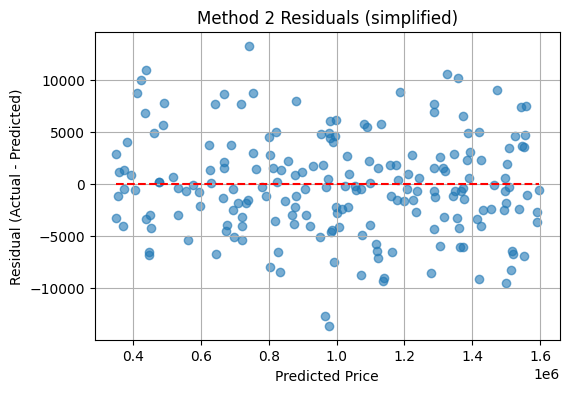

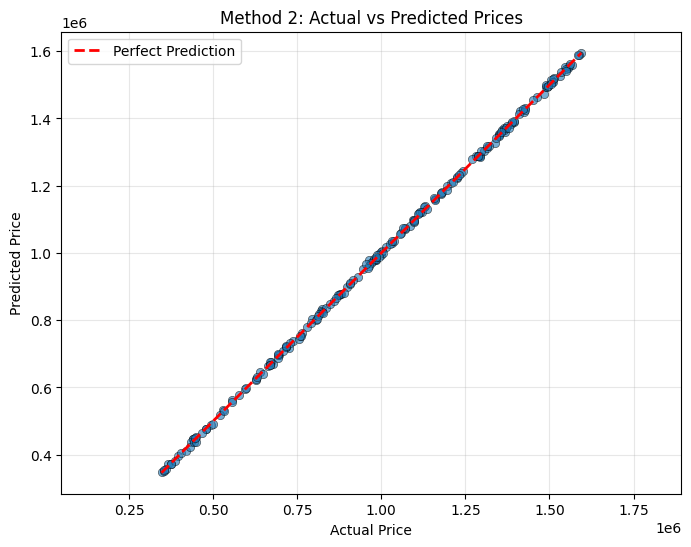

     Surface  Actual Price  Predicted Price
521    224.7     1226311.0        1223526.0
737    146.6      824324.0         832750.0
740    119.3      695643.0         696153.0
660    279.0     1495765.0        1495219.0
411    228.6     1243648.0        1243040.0


In [14]:
#Methode 2 - simplified (no CV)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fit a simple linear regression on the training set
model = LinearRegression()
model.fit(X_train, y_train.values.ravel())

# Predictions on train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Compute metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {rmse_train:,.2f}")
print(f"Test RMSE: {rmse_test:,.2f}")
print(f"Test MAE: {mae_test:,.2f}")
print(f"Test R2: {r2_test:.4f}")

# Residuals plot (test)
residuals = y_test.values.ravel() - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.hlines(0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Method 2 Residuals (simplified)')
plt.grid(True)
plt.show()

# NEW: Scatter plot of actual vs predicted values for Method 2
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Method 2: Actual vs Predicted Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# Minimal comparison DataFrame
results_sklearn = pd.DataFrame({
    'Actual Price': y_test.round(0),
    'Predicted Price': np.round(y_test_pred, 0)
})
results_sklearn['Surface'] = X_test['Surface'].values
print(results_sklearn[['Surface', 'Actual Price', 'Predicted Price']].head())

In [15]:
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


TensorFlow model summary:


c:\Users\HP\Documents\github_project\atelier_kdd\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

------------------------------
TensorFlow model training complete.
------------------------------
Method 3 test RMSE: 4,827.12
Method 3 test MAE: 3,754.71
Method 3 test R2: 0.9998
Learned Slope (Weight): 5008.7676
Learned Intercept (Bias): 97531.9817
------------------------------
Prediction results on the test set (first 5 rows):
     Surface  Actual Price  Predicted Price
521    224.7     1226311.0        1223002.0
737    146.6      824324.0         831817.0
740    119.3      695643.0         695078.0
660    279.0     1495765.0        1494978.0
411    228.6     1243648.0        1242536.0


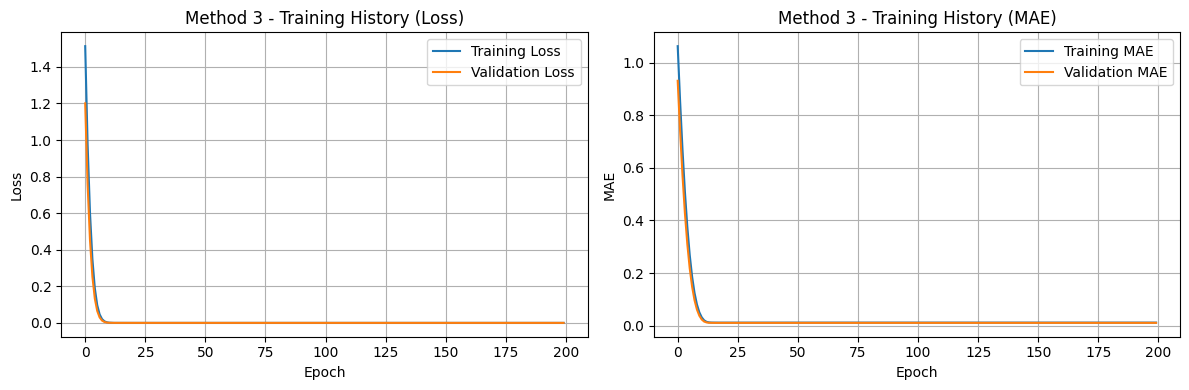

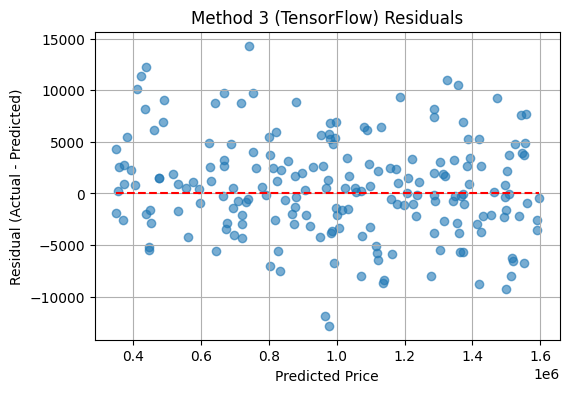

In [16]:
#methode3

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Step 1: Prepare and scale the data ---

# For reproducibility of TensorFlow operations
tf.random.set_seed(42)
np.random.seed(42)

# Scale the features to improve training stability
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# --- Step 2: Build and compile the TensorFlow model ---

# 2a. Define the model architecture
# A Dense layer with 1 unit for linear regression (no activation for linear output)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1])
])

# Use a lower learning rate for more stable training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss='mean_squared_error',
    metrics=['mae']
)

print("TensorFlow model summary:")
model.summary()
print("-" * 30)

# --- Step 3: Train the model ---

# Train on scaled data with more epochs and validation monitoring
history = model.fit(
    X_train_scaled, 
    y_train_scaled, 
    epochs=200,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=0
)

print("TensorFlow model training complete.")
print("-" * 30)

# --- Step 4: Make predictions on the test set ---

# Make predictions on scaled data
y_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()

# Transform predictions back to original scale
y_pred_tf = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Calculate metrics for Method 3
rmse_m3 = np.sqrt(mean_squared_error(y_test, y_pred_tf))
mae_m3 = mean_absolute_error(y_test, y_pred_tf)
r2_m3 = r2_score(y_test, y_pred_tf)

print(f"Method 3 test RMSE: {rmse_m3:,.2f}")
print(f"Method 3 test MAE: {mae_m3:,.2f}")
print(f"Method 3 test R2: {r2_m3:.4f}")

# --- Step 5: Display results and learned parameters ---

# Extract the learned weight (slope) and bias (intercept) from the model's layer
# Transform back to original scale
weight_scaled, bias_scaled = model.layers[0].get_weights()
weight_original = weight_scaled[0][0] * (scaler_y.scale_[0] / scaler_X.scale_[0])
bias_original = scaler_y.inverse_transform([[bias_scaled[0]]])[0][0] - weight_original * scaler_X.mean_[0]

print(f"Learned Slope (Weight): {weight_original:.4f}")
print(f"Learned Intercept (Bias): {bias_original:.4f}")
print("-" * 30)

# Create a DataFrame for easy comparison
results_tf = pd.DataFrame({
    'Actual Price': y_test.round(0),
    'Predicted Price': y_pred_tf.round(0)
})
results_tf['Surface'] = X_test['Surface'].values

print("Prediction results on the test set (first 5 rows):")
print(results_tf[['Surface', 'Actual Price', 'Predicted Price']].head())

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Method 3 - Training History (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Method 3 - Training History (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot residuals for Method 3
residuals_tf = y_test.values.ravel() - y_pred_tf
plt.figure(figsize=(6,4))
plt.scatter(y_pred_tf, residuals_tf, alpha=0.6)
plt.hlines(0, xmin=y_pred_tf.min(), xmax=y_pred_tf.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Method 3 (TensorFlow) Residuals')
plt.grid(True)
plt.show()

=== PERFORMANCE COMPARISON ===
                  Method       RMSE        MAE      R²
0   Method 1 (Custom GD)  4758.5363  3729.1206  0.9998
1     Method 2 (Sklearn)  4758.2855  3728.5933  0.9998
2  Method 3 (TensorFlow)  4827.1152  3754.7108  0.9998

Best performing method by metric:
Lowest RMSE: Method 2 (Sklearn)
Lowest MAE: Method 2 (Sklearn)
Highest R²: Method 2 (Sklearn)


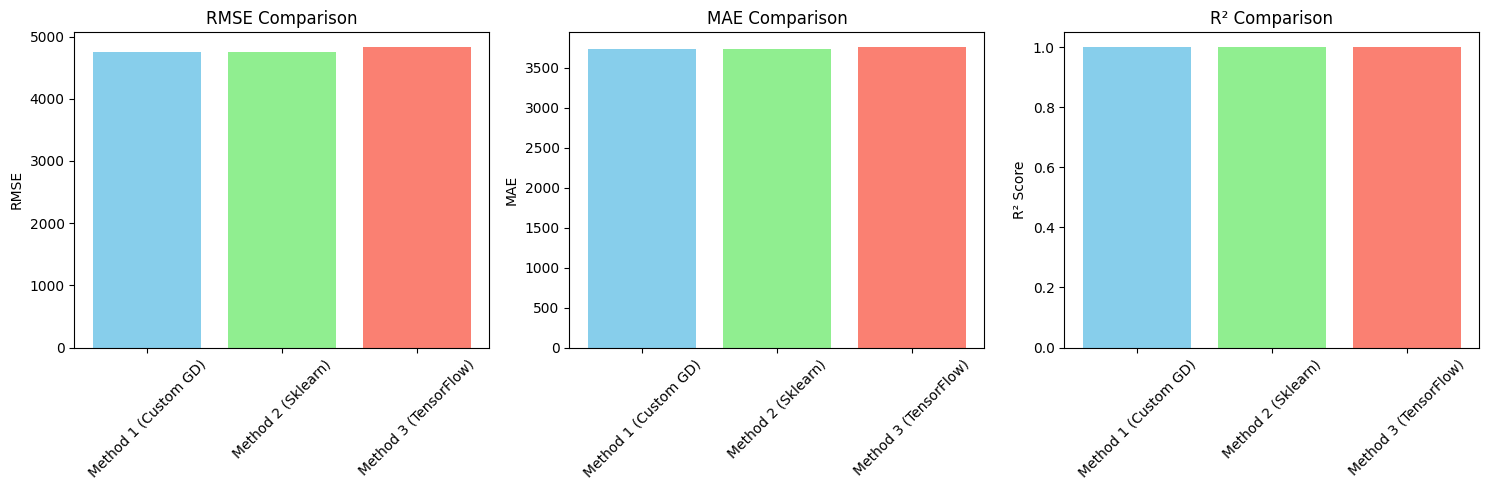

In [17]:
# Performance Comparison Table
import pandas as pd

# Note: These variables should be available from running the previous cells
# If not, you'll need to run the previous cells first

try:
    # Create comparison table
    comparison_data = {
        'Method': ['Method 1 (Custom GD)', 'Method 2 (Sklearn)', 'Method 3 (TensorFlow)'],
        'RMSE': [rmse_m1, rmse_test, rmse_m3],
        'MAE': [mae_m1, mae_test, mae_m3],
        'R²': [r2_m1, r2_test, r2_m3]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("=== PERFORMANCE COMPARISON ===")
    print(comparison_df.round(4))
    print("\nBest performing method by metric:")
    print(f"Lowest RMSE: {comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Method']}")
    print(f"Lowest MAE: {comparison_df.loc[comparison_df['MAE'].idxmin(), 'Method']}")
    print(f"Highest R²: {comparison_df.loc[comparison_df['R²'].idxmax(), 'Method']}")
    
    # Visualization of performance comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # RMSE comparison
    axes[0].bar(comparison_df['Method'], comparison_df['RMSE'], color=['skyblue', 'lightgreen', 'salmon'])
    axes[0].set_title('RMSE Comparison')
    axes[0].set_ylabel('RMSE')
    axes[0].tick_params(axis='x', rotation=45)
    
    # MAE comparison
    axes[1].bar(comparison_df['Method'], comparison_df['MAE'], color=['skyblue', 'lightgreen', 'salmon'])
    axes[1].set_title('MAE Comparison')
    axes[1].set_ylabel('MAE')
    axes[1].tick_params(axis='x', rotation=45)
    
    # R² comparison
    axes[2].bar(comparison_df['Method'], comparison_df['R²'], color=['skyblue', 'lightgreen', 'salmon'])
    axes[2].set_title('R² Comparison')
    axes[2].set_ylabel('R² Score')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
except NameError as e:
    print(f"Error: {e}")
    print("Please run all previous cells first to generate the metrics variables.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement des données et split
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Construction des pipelines
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# 3. Évaluation avec validation croisée
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

results = {}
for name, pipeline in pipelines.items():
    cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)
    results[name] = {
        'RMSE': -cv_results['test_RMSE'].mean(),
        'MAE': -cv_results['test_MAE'].mean(),
        'R2': cv_results['test_R2'].mean(),
        'MAPE': -cv_results['test_MAPE'].mean()
    }

# 4. Comparaison et visualisation
results_df = pd.DataFrame(results).T
print("Résultats de validation croisée :")
print(results_df)

# Entraînement final et résidus
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, pipeline) in enumerate(pipelines.items()):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    residuals = y_test - y_pred
    
    axes[idx].scatter(y_pred, residuals, alpha=0.5)
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlabel('Prédictions')
    axes[idx].set_ylabel('Résidus')
    axes[idx].set_title(f'{name}')

plt.tight_layout()
plt.show()



Partie 2 : Sélection de variables
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.linear_model import Lasso

# 5. Méthodes filter
# Corrélation
corr_matrix = X_train.corr()
correlation_target = pd.DataFrame(X_train).corrwith(y_train).abs().sort_values(ascending=False)
print("Corrélation avec la cible :")
print(correlation_target)

# ANOVA F-test
selector_f = SelectKBest(score_func=f_regression, k=5)
X_train_f = selector_f.fit_transform(X_train, y_train)
selected_features_f = X_train.columns[selector_f.get_support()].tolist()
print(f"\nFeatures sélectionnées (ANOVA F) : {selected_features_f}")

# Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_regression, k=5)
X_train_mi = selector_mi.fit_transform(X_train, y_train)
selected_features_mi = X_train.columns[selector_mi.get_support()].tolist()
print(f"Features sélectionnées (MI) : {selected_features_mi}")

# Comparaison des performances
filter_results = {}
for method, X_selected, features in [('ANOVA_F', X_train_f, selected_features_f), 
                                       ('MI', X_train_mi, selected_features_mi)]:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    cv_results = cross_validate(pipeline, X_selected, y_train, cv=5, scoring=scoring)
    filter_results[method] = {
        'RMSE': -cv_results['test_RMSE'].mean(),
        'R2': cv_results['test_R2'].mean()
    }

print("\nPerformances avec sélection filter :")
print(pd.DataFrame(filter_results).T)

# 6. Méthodes wrapper/embedded
# RFE
rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_].tolist()
print(f"\nFeatures sélectionnées (RFE) : {selected_features_rfe}")

# Lasso
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(StandardScaler().fit_transform(X_train), y_train)
lasso_importance = np.abs(lasso.coef_)
selected_features_lasso = X_train.columns[lasso_importance > 0].tolist()
print(f"Features sélectionnées (Lasso) : {selected_features_lasso}")

# Feature Importance Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_features_rf = feature_importance.head(5).index.tolist()
print(f"Features sélectionnées (RF Importance) : {selected_features_rf}")

# Comparaison des performances
wrapper_results = {}
for method, features in [('RFE', selected_features_rfe), 
                         ('Lasso', selected_features_lasso),
                         ('RF_Importance', selected_features_rf)]:
    X_selected = X_train[features]
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    cv_results = cross_validate(pipeline, X_selected, y_train, cv=5, scoring=scoring)
    wrapper_results[method] = {
        'RMSE': -cv_results['test_RMSE'].mean(),
        'R2': cv_results['test_R2'].mean()
    }

print("\nPerformances avec sélection wrapper/embedded :")
print(pd.DataFrame(wrapper_results).T)

# 7. Stabilité des variables sélectionnées
from sklearn.model_selection import KFold

stability_results = {feature: 0 for feature in X_train.columns}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train):
    X_fold = X_train.iloc[train_idx]
    y_fold = y_train.iloc[train_idx]
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_fold, y_fold)
    top_features = pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(5).index
    
    for feature in top_features:
        stability_results[feature] += 1

stability_df = pd.DataFrame(list(stability_results.items()), columns=['Feature', 'Selection_Count'])
stability_df = stability_df.sort_values('Selection_Count', ascending=False)
print("\nStabilité des variables (nombre de fois sélectionnées sur 10 folds) :")
print(stability_df)
Partie 3 : Gestion des données atypiques
from scipy import stats

# 8. Identification et visualisation des outliers
# Méthode Z-score
z_scores = np.abs(stats.zscore(X_train))
outliers_zscore = (z_scores > 3).any(axis=1)
print(f"Nombre d'outliers détectés (Z-score) : {outliers_zscore.sum()}")

# Méthode IQR
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Nombre d'outliers détectés (IQR) : {outliers_iqr.sum()}")

# Visualisation
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(X_train.columns):
    axes[idx].boxplot(X_train[col])
    axes[idx].set_title(col)
    axes[idx].set_ylabel('Valeur')

plt.tight_layout()
plt.show()

# 9. Impact de la suppression des outliers
# Sans outliers
X_train_no_outliers = X_train[~outliers_zscore]
y_train_no_outliers = y_train[~outliers_zscore]

outlier_results = {}

# Avec outliers
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
outlier_results['Avec_outliers'] = {
    'RMSE': -cv_results['test_RMSE'].mean(),
    'R2': cv_results['test_R2'].mean()
}

# Sans outliers
cv_results = cross_validate(pipeline, X_train_no_outliers, y_train_no_outliers, cv=5, scoring=scoring)
outlier_results['Sans_outliers'] = {
    'RMSE': -cv_results['test_RMSE'].mean(),
    'R2': cv_results['test_R2'].mean()
}

print("\nImpact de la suppression des outliers :")
print(pd.DataFrame(outlier_results).T)
Partie 4 : Validation statistique
from scipy.stats import wilcoxon, friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

# 10. Test de Diebold-Mariano (approximation avec Wilcoxon)
pipeline1 = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=42))])
pipeline2 = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])

pipeline1.fit(X_train, y_train)
pipeline2.fit(X_train, y_train)

y_pred1 = pipeline1.predict(X_test)
y_pred2 = pipeline2.predict(X_test)

errors1 = np.abs(y_test - y_pred1)
errors2 = np.abs(y_test - y_pred2)

stat, p_value = wilcoxon(errors1, errors2)
print(f"\nTest de Wilcoxon (approximation Diebold-Mariano) :")
print(f"Statistique : {stat}, p-value : {p_value}")
if p_value < 0.05:
    print("Différence significative entre les modèles")
else:
    print("Pas de différence significative")

# 11. Test de Friedman + post-hoc
models_test = {
    'RF': RandomForestRegressor(random_state=42),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'KNN': KNeighborsRegressor()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_matrix = []

for train_idx, val_idx in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    fold_scores = []
    for name, model in models_test.items():
        pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
        pipeline.fit(X_fold_train, y_fold_train)
        y_pred = pipeline.predict(X_fold_val)
        rmse = mean_squared_error(y_fold_val, y_pred, squared=False)
        fold_scores.append(rmse)
    
    scores_matrix.append(fold_scores)

scores_matrix = np.array(scores_matrix)
stat, p_value = friedmanchisquare(*scores_matrix.T)
print(f"\nTest de Friedman :")
print(f"Statistique : {stat}, p-value : {p_value}")

if p_value < 0.05:
    print("Différences significatives détectées, test post-hoc :")
    scores_df = pd.DataFrame(scores_matrix, columns=models_test.keys())
    posthoc = posthoc_nemenyi_friedman(scores_df)
    print(posthoc)
Partie 5 : Valeurs manquantes
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 12. Introduction artificielle de valeurs manquantes
np.random.seed(42)
X_train_missing = X_train.copy()
missing_rate = 0.1

for col in X_train_missing.columns:
    missing_idx = np.random.choice(X_train_missing.index, size=int(len(X_train_missing) * missing_rate), replace=False)
    X_train_missing.loc[missing_idx, col] = np.nan

print(f"Nombre de valeurs manquantes par variable :")
print(X_train_missing.isnull().sum())

# Imputation simple (moyenne)
imputer_mean = SimpleImputer(strategy='mean')
X_train_imputed_mean = pd.DataFrame(
    imputer_mean.fit_transform(X_train_missing), 
    columns=X_train.columns, 
    index=X_train.index
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

cv_results = cross_validate(pipeline, X_train_imputed_mean, y_train, cv=5, scoring=scoring)
print(f"\nPerformance avec imputation moyenne :")
print(f"RMSE : {-cv_results['test_RMSE'].mean():.4f}")
print(f"R2 : {cv_results['test_R2'].mean():.4f}")

# 13. Comparaison des méthodes d'imputation
imputation_methods = {
    'Mean': SimpleImputer(strategy='mean'),
    'Median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'MICE': IterativeImputer(random_state=42, max_iter=10)
}

imputation_results = {}

for method_name, imputer in imputation_methods.items():
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X_train_missing), 
        columns=X_train.columns, 
        index=X_train.index
    )
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    
    cv_results = cross_validate(pipeline, X_imputed, y_train, cv=5, scoring=scoring)
    imputation_results[method_name] = {
        'RMSE': -cv_results['test_RMSE'].mean(),
        'MAE': -cv_results['test_MAE'].mean(),
        'R2': cv_results['test_R2'].mean(),
        'MAPE': -cv_results['test_MAPE'].mean()
    }

# Baseline sans valeurs manquantes
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
imputation_results['Original'] = {
    'RMSE': -cv_results['test_RMSE'].mean(),
    'MAE': -cv_results['test_MAE'].mean(),
    'R2': cv_results['test_R2'].mean(),
    'MAPE': -cv_results['test_MAPE'].mean()
}

print("\nComparaison des méthodes d'imputation :")
imputation_df = pd.DataFrame(imputation_results).T
print(imputation_df)

# Visualisation
imputation_df[['RMSE', 'R2']].plot(kind='bar', figsize=(10, 6), secondary_y='R2')
plt.title('Comparaison des méthodes d\'imputation')
plt.xlabel('Méthode')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()